In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

### LOADING DATASET (TWITTER DATA)

In [3]:
dataset_path = "/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Twitter_Data.csv"
df = pd.read_csv(dataset_path)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [5]:
df = df.rename(columns={'clean_text': 'text'})

In [6]:
# Display the first few rows of the dataset
print("Original Dataset:")
print(df.head())

Original Dataset:
                                                text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0


### DATA PREPROCESSING

In [7]:
df.head()

,text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [8]:
df.shape

(162980, 2)

In [9]:
df['category'].unique()

array([-1.,  0.,  1., nan])

In [10]:
df.isnull().sum()

text        4
category    7
dtype: int64

In [11]:
df = df.dropna()

In [12]:
df.isnull().sum()

text        0
category    0
dtype: int64

In [13]:
df.head()

,text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [14]:
# Preprocess the text data
def preprocess_text(text):
    
    # Check if the value is NaN
    if pd.isna(text):
        return ""

    # Convert text to lowercase
    text = text.lower()
    
    # Remove emojis
    text = text.encode('ascii', 'ignore').decode('ascii')

    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Tokenize the text
    tokens = word_tokenize(text)

    return tokens

In [15]:
text = df["text"].apply(preprocess_text)
df["text"] = text

In [16]:
print("Preprocessed Dataset:")
print(df.head())

Preprocessed Dataset:
                                                text  category
0  [when, modi, promised, minimum, government, ma...      -1.0
1  [talk, all, the, nonsense, and, continue, all,...       0.0
2  [what, did, just, say, vote, for, modi, welcom...       1.0
3  [asking, his, supporters, prefix, chowkidar, t...       1.0
4  [answer, who, among, these, the, most, powerfu...       1.0


### DATA VISUALISATION

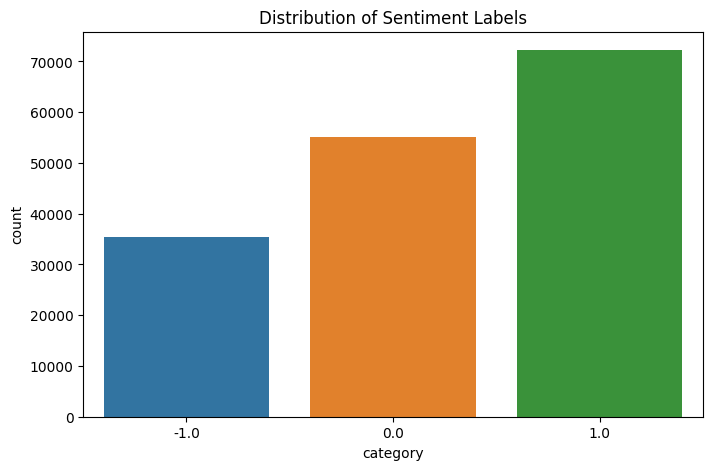

In [17]:
# Distribution of sentiment labels
plt.figure(figsize=(8, 5))
sns.countplot(x='category', data=df)
plt.title('Distribution of Sentiment Labels')
plt.show()

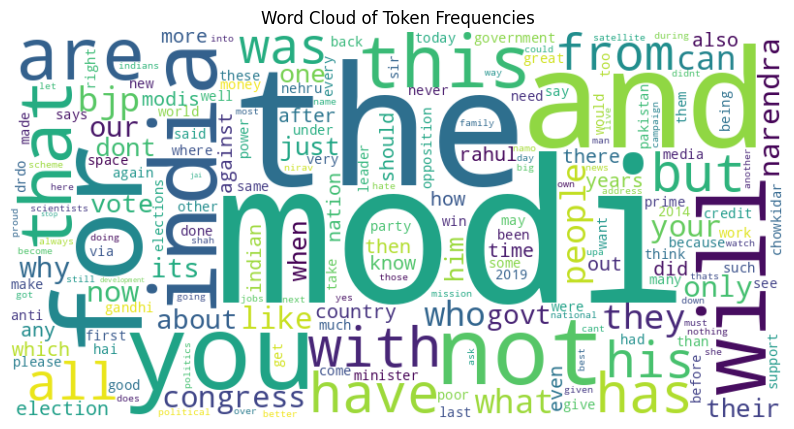

In [18]:
# Analyzing the frequency of words in the dataset

from collections import Counter
from wordcloud import WordCloud

# Tokenize and count word frequencies
all_tokens = [token for sublist in text for token in sublist]
word_freq = Counter(all_tokens)

# Word cloud visualization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Token Frequencies')
plt.show()


### FEATURE EXTRACTION

#### Convert the preprocessed text data into numerical features using TF-IDF

In [19]:
text_data = text.astype(str).tolist()

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# Fit and transform the preprocessed text data
tfidf_features = tfidf_vectorizer.fit_transform(text_data)

# Convert sparse matrix to dense array
tfidf_features_array = tfidf_features.toarray()

# Display the TF-IDF features
print(tfidf_features_array)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### TRAIN TEST SPLIT

In [20]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_features_array, df['category'], test_size=0.2, random_state=42)

### MODEL SELECTION, TRAINING AND PREDICTION

In [21]:
model = LogisticRegression()

In [22]:
model.fit(X_train, y_train)

LogisticRegression()

In [23]:
# Make predictions on the test dataset
y_pred = model.predict(X_test)

### MODEL EVALUATION

In [24]:
# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy*100, "%")

Accuracy: 83.7730870712401 %


In [25]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        -1.0       0.85      0.63      0.72      7152
         0.0       0.77      0.97      0.86     11067
         1.0       0.90      0.84      0.87     14375

    accuracy                           0.84     32594
   macro avg       0.84      0.81      0.82     32594
weighted avg       0.85      0.84      0.83     32594



### DEPLOYMENT

In [26]:
import joblib

# Save the trained model
joblib.dump(model, 'sentiment_analysis_model.pkl')

['sentiment_analysis_model.pkl']

In [27]:
# Load the trained model
model = joblib.load('/kaggle/working/sentiment_analysis_model.pkl')

In [28]:
def predict(input_text):
    # Reshape the input text into a 2D array with a single column
    input_data = np.array([input_text]).reshape(-1, 1)

    # # Transform the input text into TF-IDF features using the fitted vectorizer
    input_data = tfidf_vectorizer.transform([input_text])

    # Make predictions using the reshaped input data
    prediction = model.predict(input_data)[0]
    
    return prediction

In [29]:
input_text = "I am doing good!"

# Print the prediction
print("Predicted sentiment:", predict(input_text))

Predicted sentiment: 1.0


In [30]:
input_text = "I am sad"

# Print the prediction
print("Predicted sentiment:", predict(input_text))

Predicted sentiment: -1.0
